In [4]:
import cv2 
import numpy as np
from skimage import data, io, color, transform, exposure
import os
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from threading import Thread
from queue import Queue
import json
from pprint import pprint
import time
import operator
import copy
from collections import Counter
import scipy
from scipy import ndimage
from scipy import misc
from scipy import stats  
import scipy.misc
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



class FileVideoStream:
    def __init__(self, path, queueSize = 1024):
        self.stream = cv2.VideoCapture(path)
        self.stopped = False
        self.Q = Queue(maxsize = queueSize)
        
    def start(self):
        t = Thread(target = self.update, args = ())
        t.daemon = True
        t.start()
        return self
    
    def update(self):
        while True:
            if self.stopped:
                return
            
            if not self.Q.full():
                (grabbed, frame) = self.stream.read()
                if not grabbed:
                    self.stop()
                    return
                
                self.Q.put(frame)
    def read(self):
        return self.Q.get()
    
    def more(self):
        return self.Q.qsize() > 0
    
    def stop(self):
        self.stopped = True


In [5]:
def findmaximumpeople(json_folder_dir, jsons, id0, idn):
    
    if not id0 == idn:
        midval = (id0 + idn)//2
        leftval = findmaximumpeople(json_folder_dir, jsons, id0, midval)
        rightval = findmaximumpeople(json_folder_dir, jsons, midval + 1, idn)
        
        if leftval >= rightval:
            return leftval
        else:
            return rightval
    else:
        with open((json_folder_dir + jsons[id0])) as f:
            data = json.load(f)
        
        number = 0
        
        for item in data['people']:
            data_points = item['pose_keypoints_2d']
            
            total_certainty = 0
            
            n_points = len(data_points)
            
            for k in range(0, n_points - 1, 3):
                total_certainty += data_points[2 + k]
                
            total_certainty = total_certainty / 26
        
            if (total_certainty >= 0.5):
                number += 1

                
        return number
    

In [6]:
def data_points(jsons, json_folder_dir):
    data_points = []
    
    for i in range(0, len(jsons)):
        data_points.append([])
        with open((json_folder_dir + jsons[i])) as f:
            data = json.load(f)
        
        n_people = len(data['people'])
    
        for j in range(0, n_people):
            data_points[i].append([])
            datas = data['people'][j]['pose_keypoints_2d']
        
            for k in range(0, len(datas)):
                data_points[i][j].append(datas[k])
                
    return data_points

In [7]:
def data_classification(data):
    body_label = {0:"Nose", 1:"Neck", 2:"RShoulder", 3:"RElbow", 4:"RWrist", 5:"LShoulder", 6:"LElbow", 7:"LWrist", 8:"MidHip", 9:"RHip", 10:"RKnee", 11:"RAnkle", 12:"LHip", 13:"LKnee",14:"LAnkle", 15:"REye", 16:"LEye", 17:"REar", 18:"LEar", 19:"LBigToe", 20:"LSmallToe", 21:"LHeel", 22:"RBigToe", 23:"RSmallToe", 24:"RHeel"}
    parts = {}
    people = {}
    
    for person in range(0, len(data)):
        points = data[person]
        for i in range(0, len(points)):
            parts[body_label[i]] = points[i]
        
        people[person] = parts
        parts = {}
        
    return people

In [8]:
def organise_data(data):
    total = len(data)
    people_body_point = {}
    
    for i in range(0, total):
        people = len(data[i])
        frame_points = {}
        id_number = 0
        if people != 0:
            for j in range(0, people):
                points = data[i][j]
                n_points = len(points)
                body_points = []
                data_certainty = 0
                for k in range(0, n_points - 1, 3):
                    body_points.append((points[0 + k], points[1 + k]))
                    data_certainty += points[2 + k]
                    
                
                data_certainty = data_certainty / 26
                
                if data_certainty >= 0.5:
                    frame_points[id_number] = body_points
                    id_number += 1

            
            organised = data_classification(frame_points)
            people_body_point[i] = organised
        
    return people_body_point

In [9]:
def read_jsons(folder):
    jsons = [json for json in os.listdir(folder) if json.endswith(".json")]
    
    return jsons

In [10]:
def id_assigned(file, data, start, maximumPeople, output):
    loading = False
        
    fvs = cv2.VideoCapture(file)
    
    if start == 0:
        success, frame = fvs.read()
    else:
        for k in range(start):
            success, frame = fvs.read()
    

            
    i = start
    
    previous_id = []
    new_id = []
    
    used_id = []
    id_people = {}
    
    previous_people = 0
    
    new_organised = {}
    
    video = cv2.VideoWriter(output,cv2.VideoWriter_fourcc(*"MJPG"), 30, (1920,1080),True)
        
    while success:
        
        id_tagged_point = {}
               
        if i in data:
            
            people = len(data[i])
            
            new_id = []
                    
            used_id = []
            
            for j in range(people):
                if not (j in previous_id):
                    new_id.append(j)
                            
            hsv = cv2.cvtColor(cv2.GaussianBlur(frame, (5,5), 0), cv2.COLOR_BGR2HSV)
            
            for j in range(people):
                id_hue = []
                id_saturation = []
                id_value = []
                id_color = []
                tmp_points = copy.deepcopy(data[i][j])
                x_points = copy.deepcopy(data[i][j])                
                y_points = {}
                total_del = 0
            
                for point in tmp_points:
                    if x_points[point][0] == 0:
                        del x_points[point]
                        total_del += 1
                    if tmp_points[point][1] != 0:
                        y_points[point] = tmp_points[point][1]
                    
                
#                 Get the position to read the pixel values
                neck = copy.deepcopy(tmp_points['Neck'])
                midHip = copy.deepcopy(tmp_points['MidHip'])
#                 leftElbow = copy.deepcopy(tmp_points['LElbow'])
                
#                 Pixels which are equivalent to person
                midX = int((neck[0] + midHip[0]) / 2)
                midY = int((neck[1] + midHip[1]) / 2)
                
#                 midX = int(neck[0])
#                 midY = int(neck[1] + 10)

#                 midX = int(leftElbow[0])
#                 midY = int(leftElbow[1])
            
                minY = min(y_points.items(), key = operator.itemgetter(1))[1]
                maxY = max(y_points.items(), key = operator.itemgetter(1))[1]
                

                maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
                minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]
                
                minY = int(minY)
                maxY = int(maxY)
                minX = int(minX)
                maxX = int(maxX)
                
                
                
#                 Get the hsv values for surrounding pixel arounnd neck
                for p in range(midY - 5, midY + 5):
                    for q in range(midX - 5, midX + 5):
                        id_hue.append([hsv[p][q][0]])
                        id_saturation.append([hsv[p][q][1]])
                
#                 Get frame of the person              
                person_frame = np.zeros(((maxY - minY), (maxX - minX), 3), dtype = np.uint8)
                for y in range(minY, maxY):
                    for x in range(minX, maxX):
                            person_frame[y - minY][x - minX] = hsv[y][x]
            
                hist_hue = cv2.calcHist([person_frame], [0], None, [25], [0, 256])
                hist_hue = cv2.normalize(hist_hue, hist_hue).flatten()
                hist_saturation = cv2.calcHist([person_frame], [1], None, [25], [0,256])
                hist_saturation = cv2.normalize(hist_saturation, hist_saturation).flatten()
                
                if previous_people < people:

                    score = {}
    
                    if j in id_people:
                        
                        for hists in id_people:
                            if not(hists in used_id):
                                previous_hue = id_people[hists]["Hue"]
                                previous_saturation = id_people[hists]["Saturation"]
                                average_number = id_people[hists]["Total"]

                                previous_hue = previous_hue / average_number
                                previos_saturation = previous_saturation / average_number

                                hue_correl = abs(cv2.compareHist(hist_hue, previous_hue, cv2.HISTCMP_CORREL))
                                saturation_correl = abs(cv2.compareHist(hist_saturation, previous_saturation, cv2.HISTCMP_CORREL))

                                score[hists] = (hue_correl + saturation_correl)/2

                        if score:

                            highest = max(score.items(), key=operator.itemgetter(1))[0]
                            used_id.append(highest)
                            id_people[highest]["Hue"] += hist_hue
                            id_people[highest]["Saturation"] += hist_saturation
                            id_people[highest]["Total"] += 1

                            cv2.rectangle(frame, (minX, minY), (maxX, maxY), (0, 255, 0), 3)
                            cv2.putText(frame, str(highest), (int(minX), int(minY)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
                            
                            id_tagged_point[highest] = tmp_points
                            
                            
                    else:

                        id_number = new_id.pop(0)
                        used_id.append(id_number)

                        person_hist = {}

                        person_hist["Hue"] = hist_hue
                        person_hist["Saturation"] = hist_saturation
                        person_hist["Total"] = 1


                        id_people[id_number] = person_hist

                        id_tagged_point[id_number] = tmp_points
                        
                        cv2.rectangle(frame, (minX, minY), (maxX, maxY), (0, 255, 0), 3)

                        cv2.putText(frame, str(id_number),(int(minX),int(minY)), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),1,cv2.LINE_AA)
                        
                    
                else:
                    score = {}
                                
                    for hists in id_people:
                        
                        if (hists in previous_id) and not (hists in used_id):
                            previous_hue = id_people[hists]["Hue"]
                            previous_saturation = id_people[hists]["Saturation"]
                            average_number = id_people[hists]["Total"]
                                
                            previous_hue = previous_hue / average_number
                            previos_saturation = previous_saturation / average_number
                            hue_correl = abs(cv2.compareHist(hist_hue, previous_hue, cv2.HISTCMP_CORREL))
                            saturation_correl = abs(cv2.compareHist(hist_saturation, previous_saturation, cv2.HISTCMP_CORREL))
                                                        
                            score[hists] = (hue_correl + saturation_correl) / 2
                                        
                    if score:
                        highest = max(score.items(), key=operator.itemgetter(1))[0]
                        used_id.append(highest)
                        id_people[highest]["Hue"] += hist_hue
                        id_people[highest]["Saturation"] += hist_saturation
                        id_people[highest]["Total"] += 1
                        
                        id_tagged_point[highest] = tmp_points

                        cv2.rectangle(frame, (minX, minY), (maxX, maxY), (0, 255, 0), 3)
                        cv2.putText(frame, str(highest), (int(minX), int(minY)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)                        
                    
                    
        else:
            people = 0
        
        previous_id = copy.deepcopy(used_id)
        previous_people = copy.deepcopy(people)
        
        new_organised[i] = id_tagged_point
            
        video.write(frame)
#         cv2.imshow("Video", frame)
#         if cv2.waitKey(20) & 0xFF == ord('q'):
#             break

        
        success, frame = fvs.read()
        
        i += 1
        
    video.release()
    print("Released")
#     cv2.destroyAllWindows()
    return new_organised

In [11]:
def section_player(file, data, start, end):
    fvs = cv2.VideoCapture(file)
    
    if start == 0:
        success, frame = fvs.read()
    else:
        for k in range(start):
            success, frame = fvs.read()
                
    for i in range(start, end + 1):
        people = len(data[str(i)])
        
        for j in data[str(i)]:
            tmp_points = copy.deepcopy(data[str(i)][j])
            x_points = copy.deepcopy(data[str(i)][j])
            y_points = {}
            total_del = 0
            
            for point in tmp_points:
                if x_points[point][0] == 0:
                    del x_points[point]
                    total_del += 1
                if tmp_points[point][1] != 0:
                    y_points[point] = tmp_points[point][1]
                    
            
            minY = min(y_points.items(), key = operator.itemgetter(1))[1]
            maxY = max(y_points.items(), key = operator.itemgetter(1))[1]


            maxX, GY = max(x_points.items(), key = operator.itemgetter(1))[1]
            minX, GY = min(x_points.items(), key = operator.itemgetter(1))[1]

            minY = int(minY)
            maxY = int(maxY)
            minX = int(minX)
            maxX = int(maxX)
            
            cv2.rectangle(frame, (minX, minY), (maxX, maxY), (0, 255, 0), 3)
            cv2.putText(frame, str(j), (int(minX), int(minY)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow("Video", frame)
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
            
        success, frame = fvs.read()
        
#         i += 1

            
    cv2.destroyAllWindows()


In [12]:
def section_separator(data, start, end):
    
    exercise_one = {}
    exercise_two = {}
    
                
    for i in range(start, end + 1):
        
        for j in data[str(i)]:
            if j == '0':
                exercise_one[i] = data[str(i)][j]
            else:
                exercise_two[i] = data[str(i)][j]
        
#         i += 1

    return exercise_one, exercise_two

In [13]:
def data_pca(data, start, end):    
    exercise_one = {}
    exercise_two = {}

                
    for i in range(start, end + 1):
        
        for j in data[str(i)]:
            if j == '0':
                body_point = []
                for part in data[str(i)][j]:
                    body_point += data[str(i)][j][part]
                    
                exercise_one[i] = body_point
            else:
                body_point = []
                for part in data[str(i)][j]:
                    body_point += data[str(i)][j][part]
                    
                exercise_two[i] = body_point
        
#         i += 1

    return exercise_one, exercise_two

In [14]:
def only_hand(data, start, end):
    
    hand = {}
    
    for i in range(start, end + 1):
        body_point = []
        for j in data[i]:
#             if j == 'LWrist' or j == "RWrist":
            if j == 'LWrist':

                body_point += data[i][j]
                
        hand[i] = body_point
        
    return hand

In [15]:
def flatten(exercise):
    
    flattered = []
    
    for i in exercise:
        for j in exercise[i]:
            flattered = flattered + exercise[i][j]
            
    return flattered

In [16]:
def plotSkeleton(data):
    
    fig = plt.subplot()
    
    fig.set_xlim(0, 1920)
    fig.set_ylim(0, 1080)
    first = True
    
#     fig.set_ylim(fig.get_ylim()[::-1])

    for frame in data:
    
        if not first:
            fig.clear()
        else:
            first = False
            
        fig.scatter(0,1080)
        fig.scatter(1920, 1080)
        fig.scatter(0,0)
            
        if len(data[frame]) != 0:
            for body_part in data[frame]:
                fig.scatter(data[frame][body_part][0], 1080 - data[frame][body_part][1])
        plt.pause(0.001)
        
    plt.show()

In [17]:
json_folder = 'DS3'
json_folder_slash = 'DS3/'

jsons = read_jsons(json_folder)

number_of_people = findmaximumpeople(json_folder_slash, jsons, 0, (len(jsons) - 1))

data_points1 = data_points(jsons, json_folder_slash)

In [18]:
people_body_part_points = organise_data(data_points1)

In [19]:
# pprint(people_body_part_points)
# print(number_of_people)

In [20]:
# point = people_body_part_points[16][1]
# print(max(people_body_part_points.items(), key = operator.itemgetter(1))[1])
# print(min(people_body_part_points.items(), key = operator.itemgetter(1))[1])

In [21]:
# plot_data_points('result2.mp4', data_points1)

In [22]:
# plot_box('result2.mp4', people_body_part_points)

In [23]:
# id_tagged_data = id_assigned('DS2.MOV', people_body_part_points, 0, number_of_people, "ID_track_DS2.avi")

In [24]:
# with open('DS3.json', 'w') as fp:
#     json.dump(id_tagged_data, fp)

In [25]:
with open('DS3.json', 'r') as fp:
    data = json.load(fp)

with open('DS2.json', 'r') as fp:
    ds2_data = json.load(fp)

In [57]:
def pcaAnalysis(data, start, end, number):
    df = pd.DataFrame(data=data).transpose()
    features = []

    for i in range(0, number):
        features.append(i)
        
    frame = []

    for i in range(start, end + 1):
        frame.append(i)
        
    x = df.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    
    
    if (number > 2):
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(x)
        print(pca.explained_variance_ratio_)
        principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    
        fig = plt.figure(figsize = (20,15))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Frame', fontsize = 15)
        ax.set_ylabel('Principal Component 1', fontsize = 15)
        ax.set_title('PCA 1 against time', fontsize = 20)
    
        thresholded = []
        new_frame = []

        for i in range(len(frame)):
            if principalDf.loc[i, 'principal component 1'] < 30:
                thresholded.append(principalDf.loc[i, 'principal component 1'])
                new_frame.append(i)    

        ax.scatter(new_frame, thresholded, s = 50)
        ax.plot(new_frame, thresholded, '-o')

    else:
        fig = plt.figure(figsize = (20,15))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Frame', fontsize = 15)
        ax.set_ylabel('Hand points', fontsize = 15)
        ax.set_title('Hand points against frame', fontsize = 20)
        
        new_data = []
        for i in data:
            new_data.append(data[i][1])
        
        ax.plot(frame, new_data, '-o')

    plt.show()

In [26]:
# section_player('DS2.MOV', data, 0, 4000)

In [27]:
# section_player('DS1.MOV', ds2_data, 1180, 1910)
# 135, 800
# 1180, 1910
# 2700, 3350
# 3600, 4280

In [28]:
# section_player('DS2.MOV', data, 4585, 5325)

In [29]:
exercise_one, exercise_two = section_separator(ds2_data, 135, 800)
exercise_four, exercise_three = section_separator(ds2_data, 1230, 1910)
exercise_five, exercise_six = section_separator(ds2_data, 2700, 3350)
exercise_eight, exercise_seven = section_separator(ds2_data, 3600, 4280)

In [30]:
exercise_9, exercise_10 = section_separator(data, 210, 930)
exercise_12, exercise_11 = section_separator(data, 1250, 1990)
exercise_13, exercise_14 = section_separator(data, 2330, 2980)
exercise_16, exercise_15 = section_separator(data, 3725, 4350)
exercise_17, exercise_18 = section_separator(data, 4585, 5325)

In [31]:
%matplotlib inline

In [32]:
# plotSkeleton(exercise_two)

In [33]:
pca_data_one, pca_data_two = data_pca(ds2_data, 135, 800)
pca_data_four, pca_data_three = data_pca(ds2_data, 1230, 1910)
pca_data_five, pca_data_six = data_pca(ds2_data, 2700, 3350)
pca_data_eight, pca_data_seven = data_pca(ds2_data, 3600, 4280)
pca_data_9, pca_data_10 = data_pca(data, 210, 930)
pca_data_12, pca_data_11 = data_pca(data, 1250, 1990)
pca_data_13, pca_data_14 = data_pca(data, 2330, 2980)
pca_data_16, pca_data_15 = data_pca(data, 3725, 4350)
pca_data_17, pca_data_18 = data_pca(data, 4585, 5325)


Squat 1
[0.5342761 0.1986421]


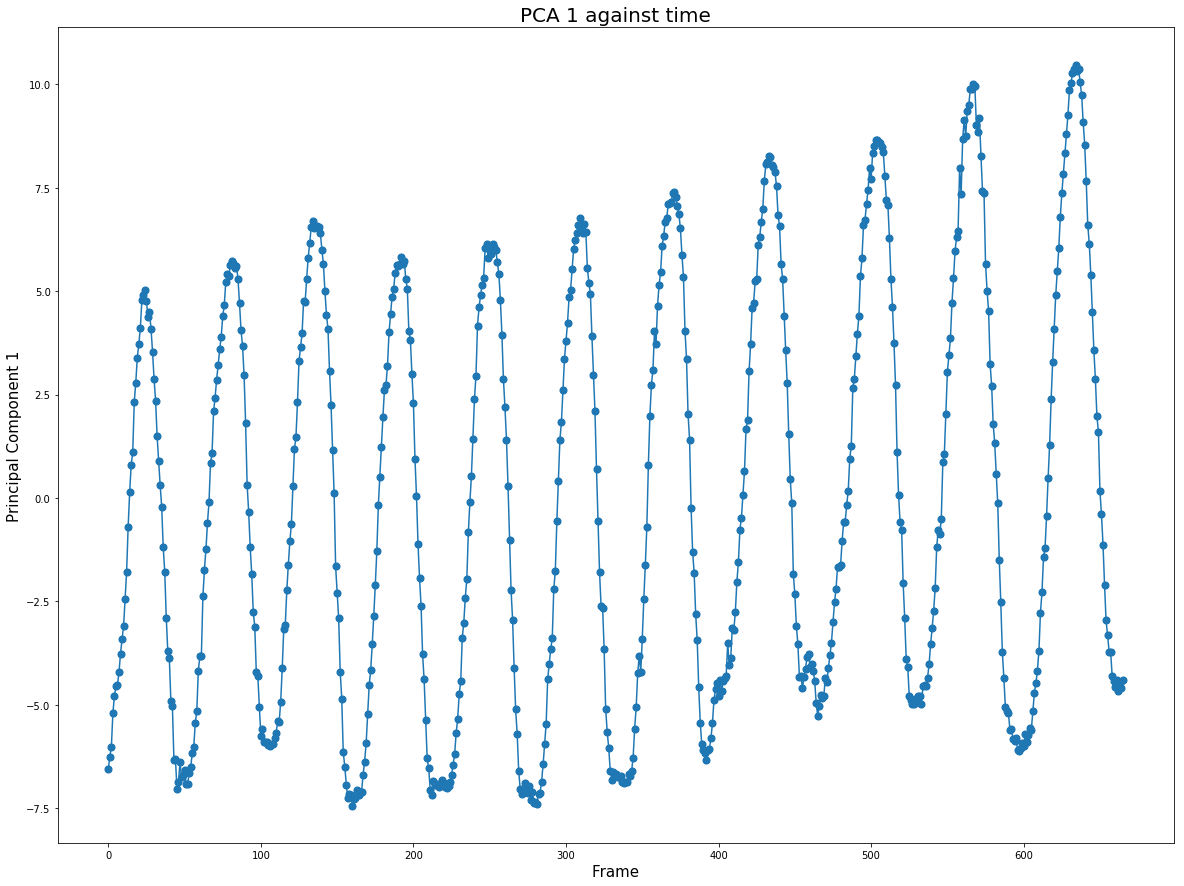

Arm 1
[0.20099437 0.13068048]


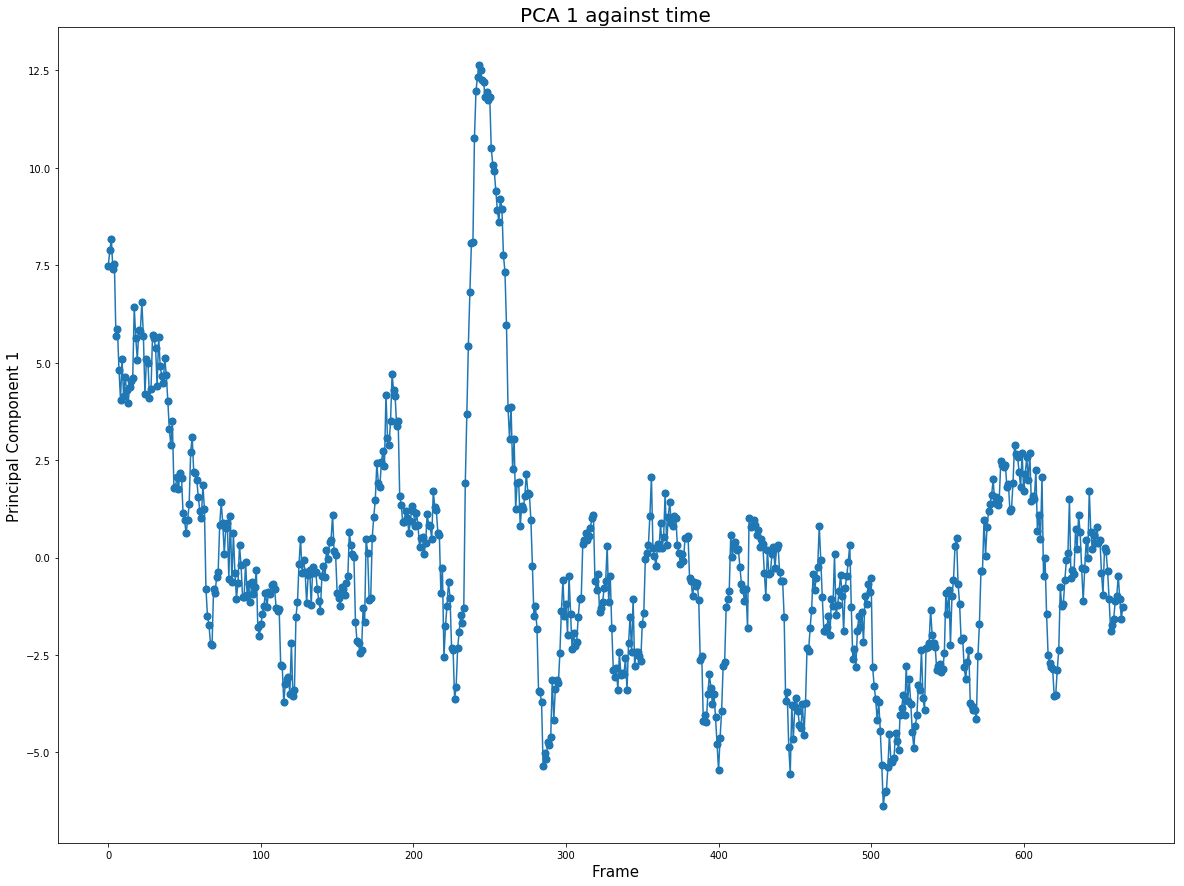

Squat 2
[0.61262403 0.09414436]


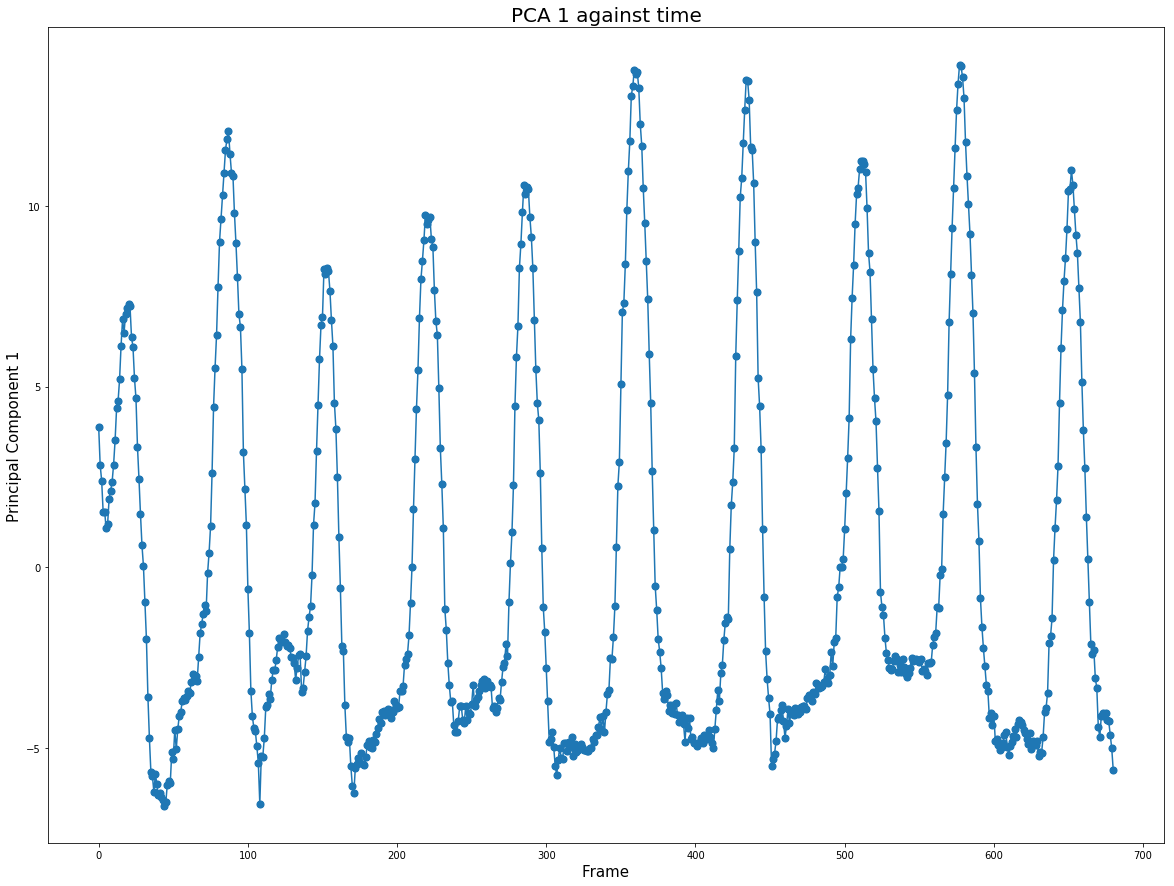

Arm 2
[0.39225062 0.11610333]


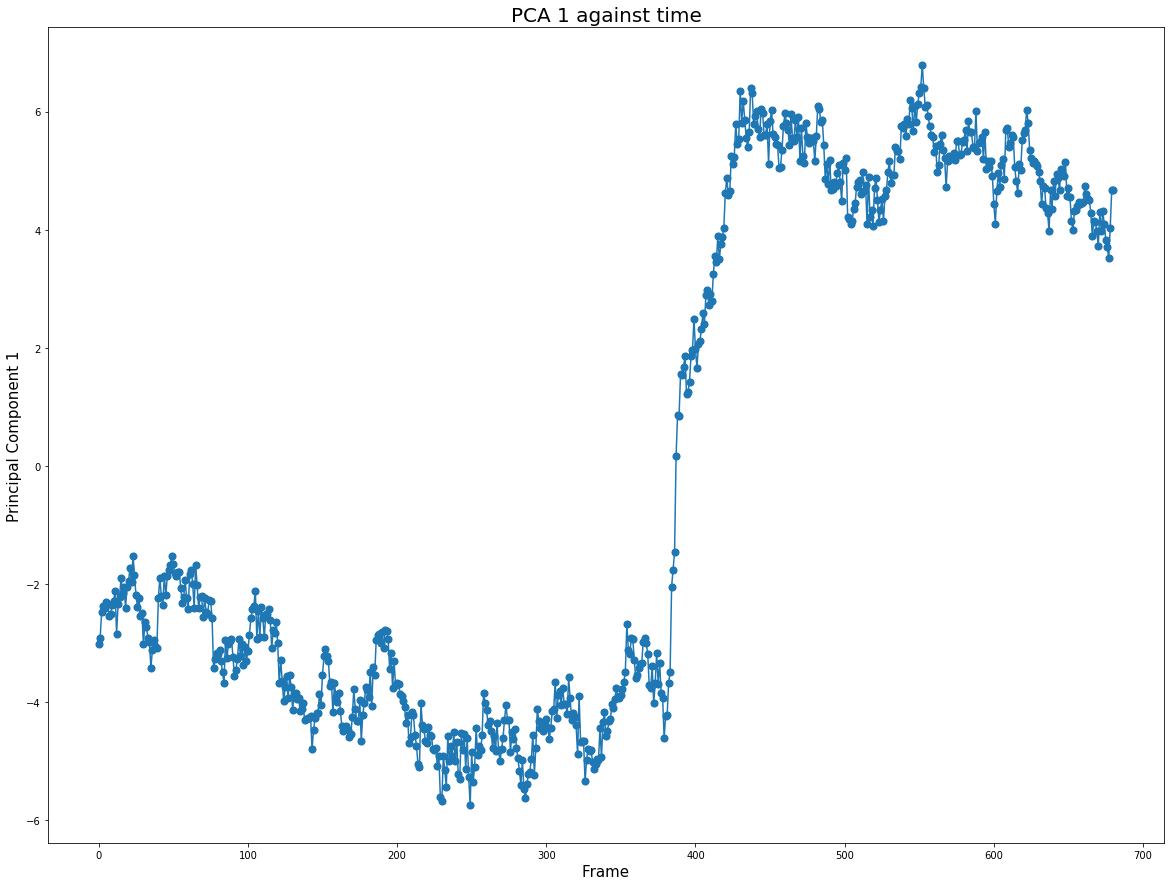

Squat 3
[0.53422858 0.13132557]


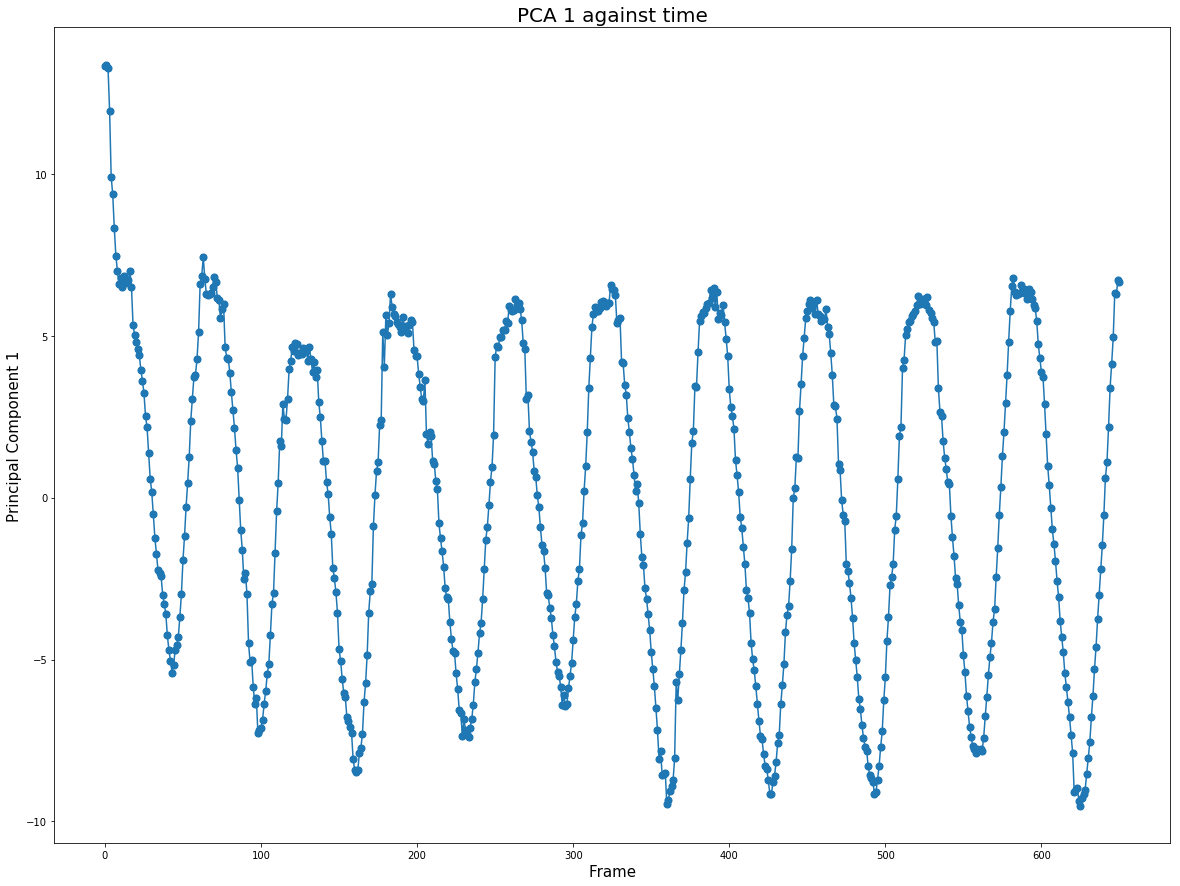

Arm 3
[0.31883504 0.14796692]


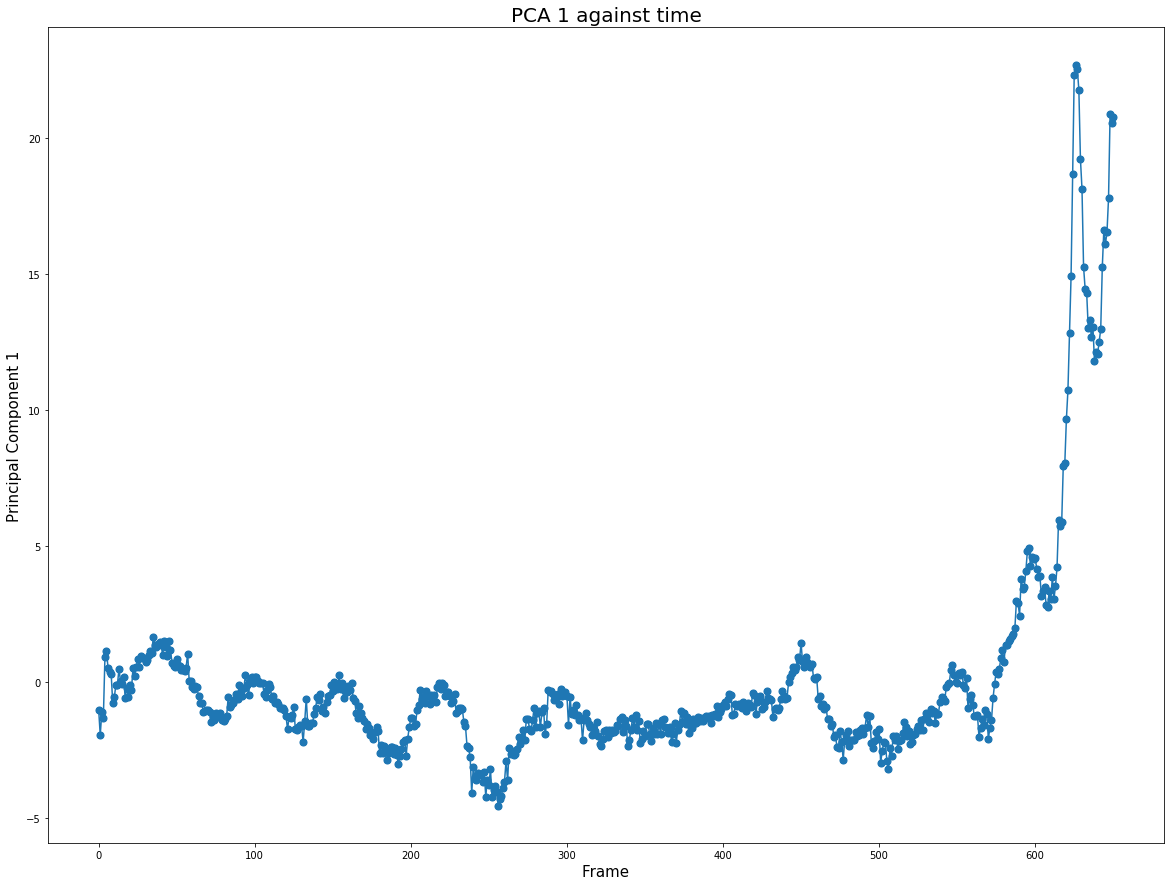

Squat 4
[0.54363724 0.15521755]


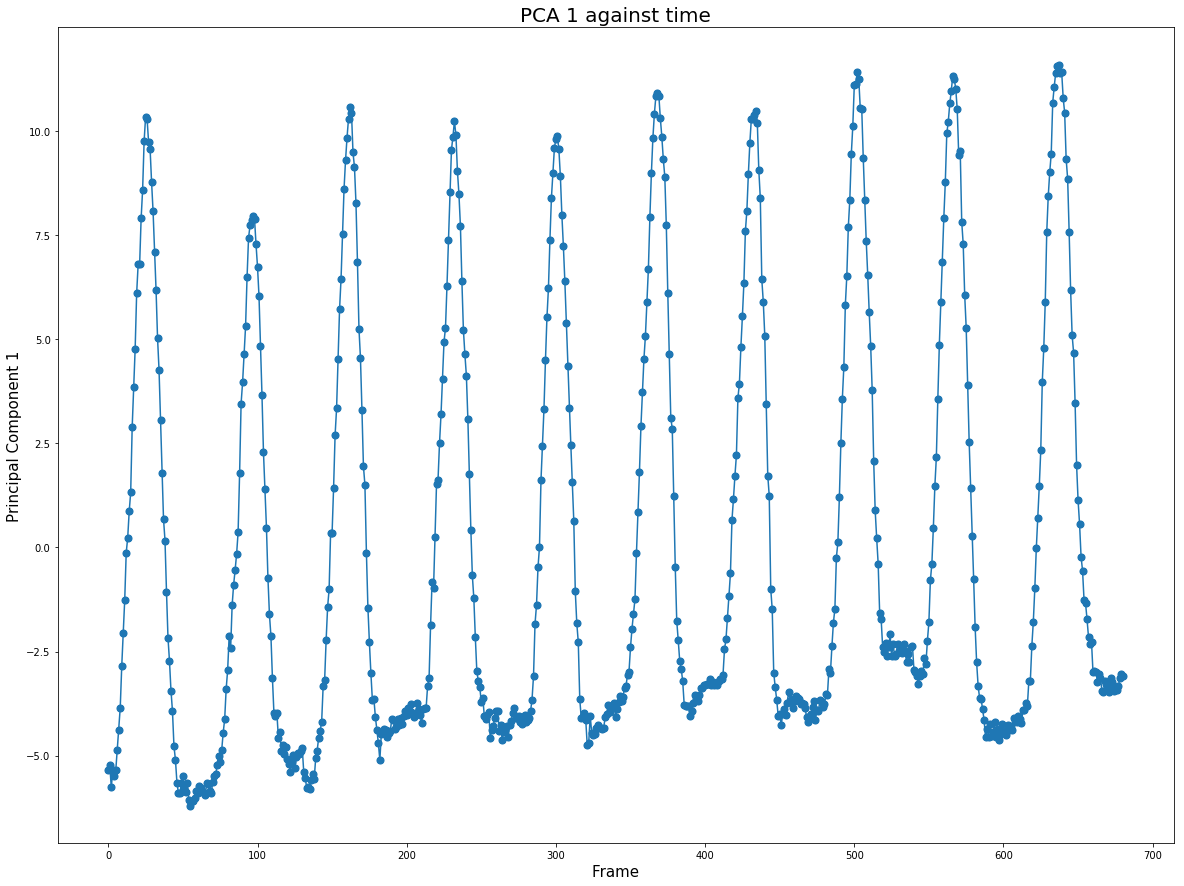

Arm 4
[0.51748397 0.11527356]


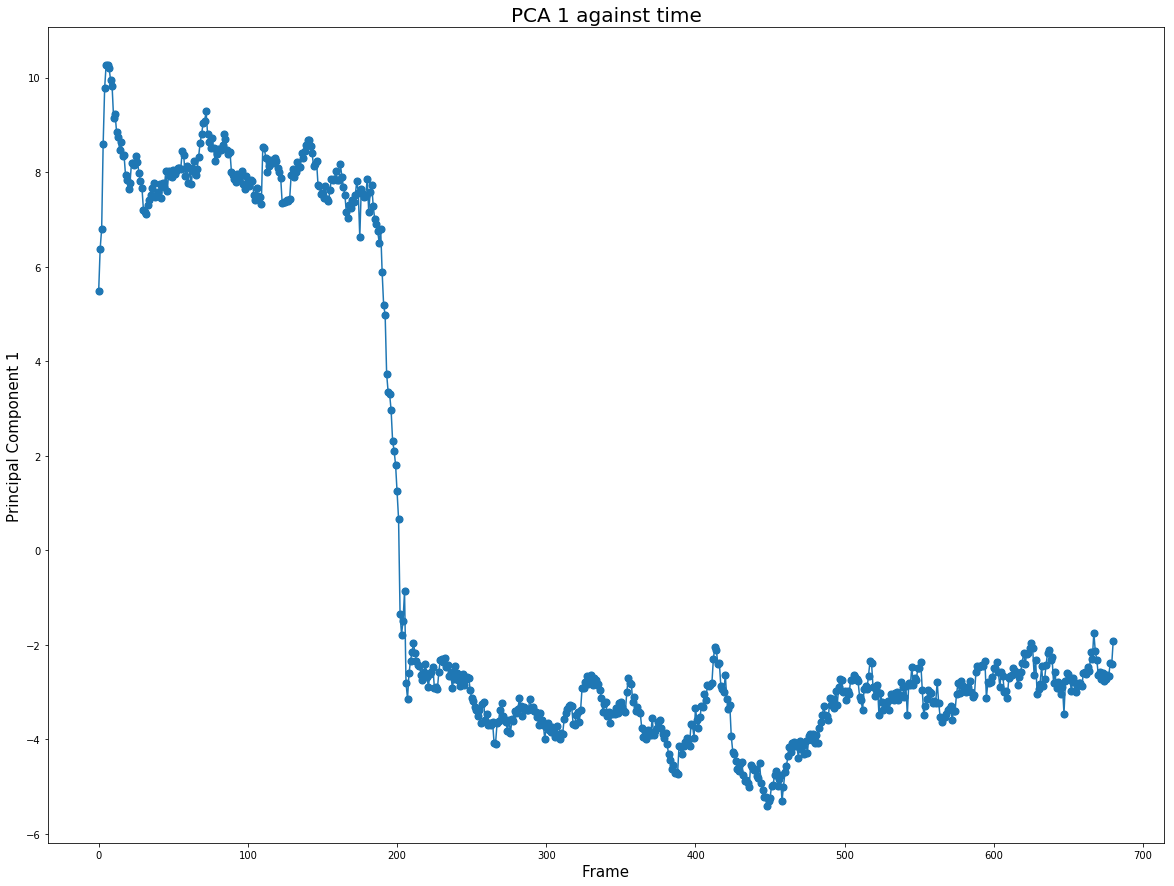

Squat 5
[0.59938635 0.0925961 ]


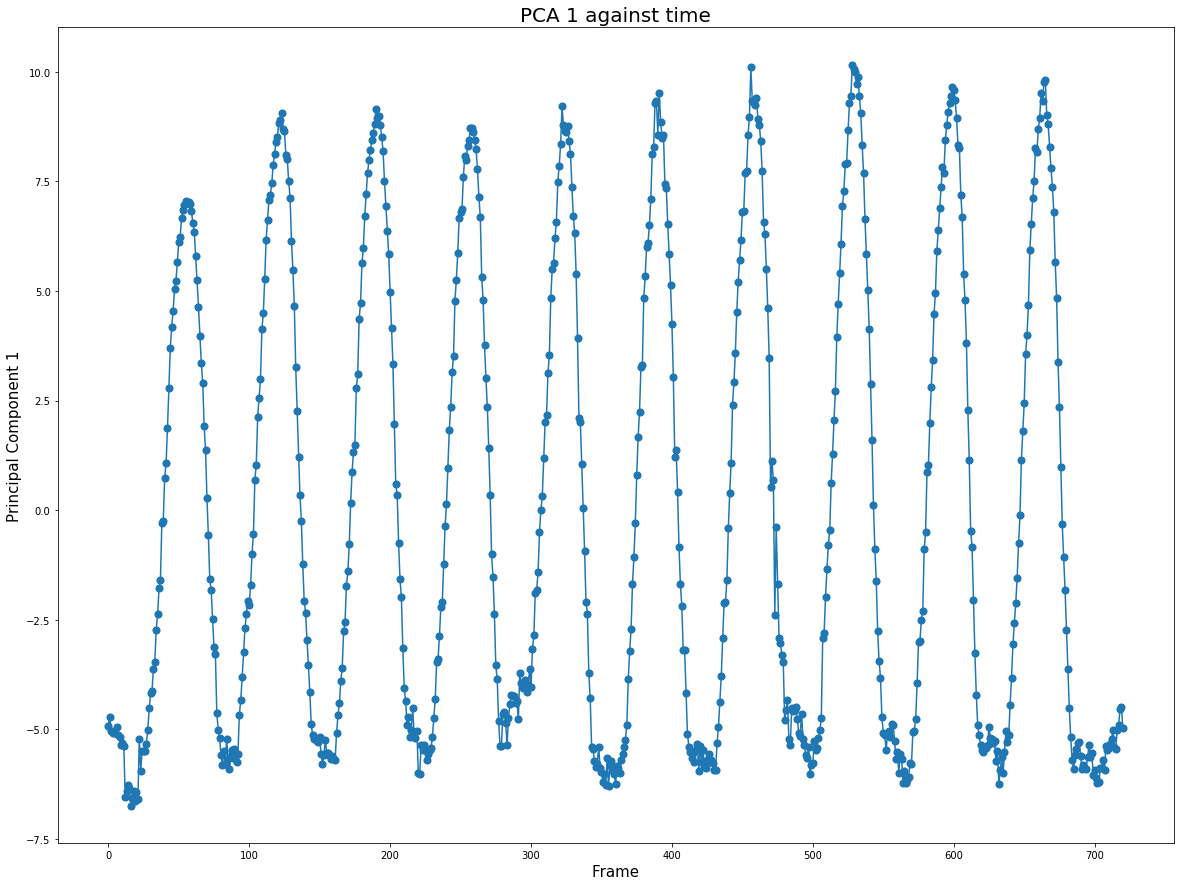

Arm 5
[0.29901195 0.12098869]


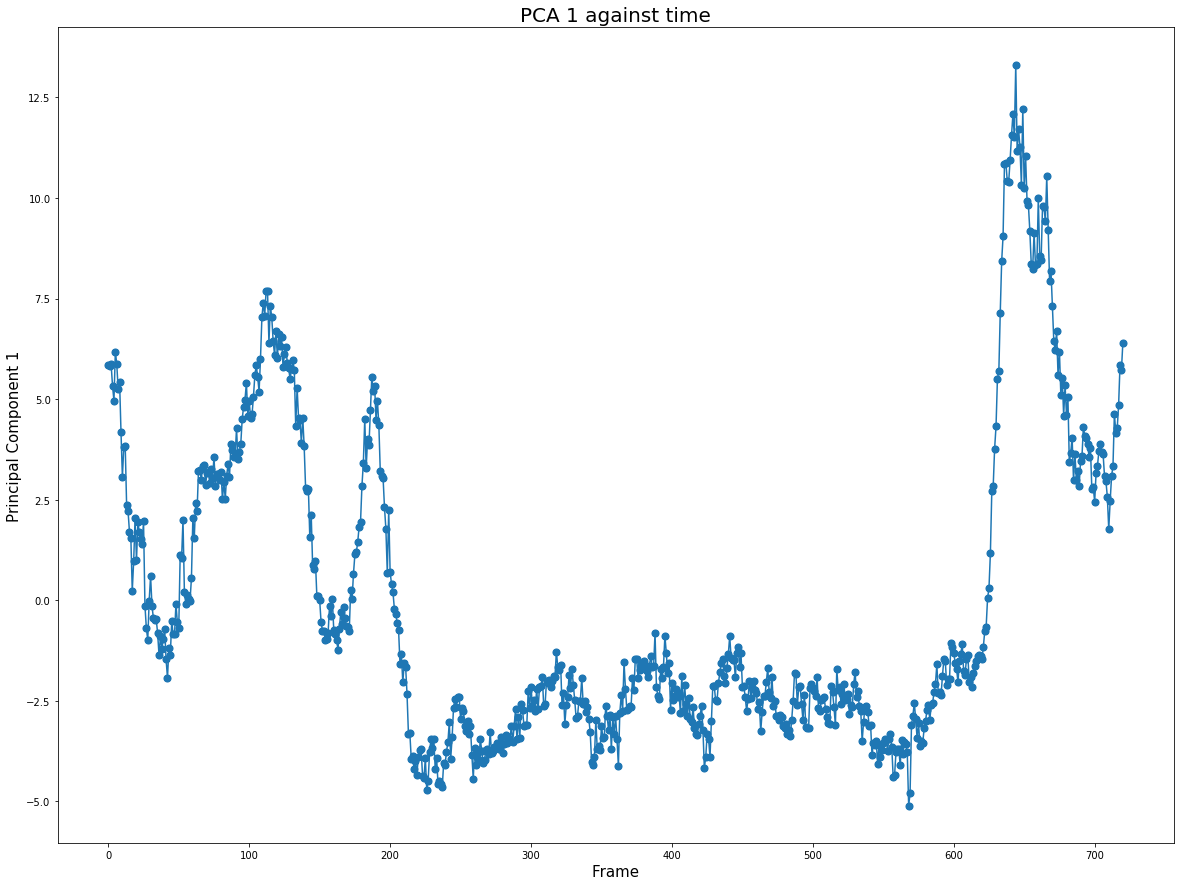

Squat 6
[0.55043099 0.27400906]


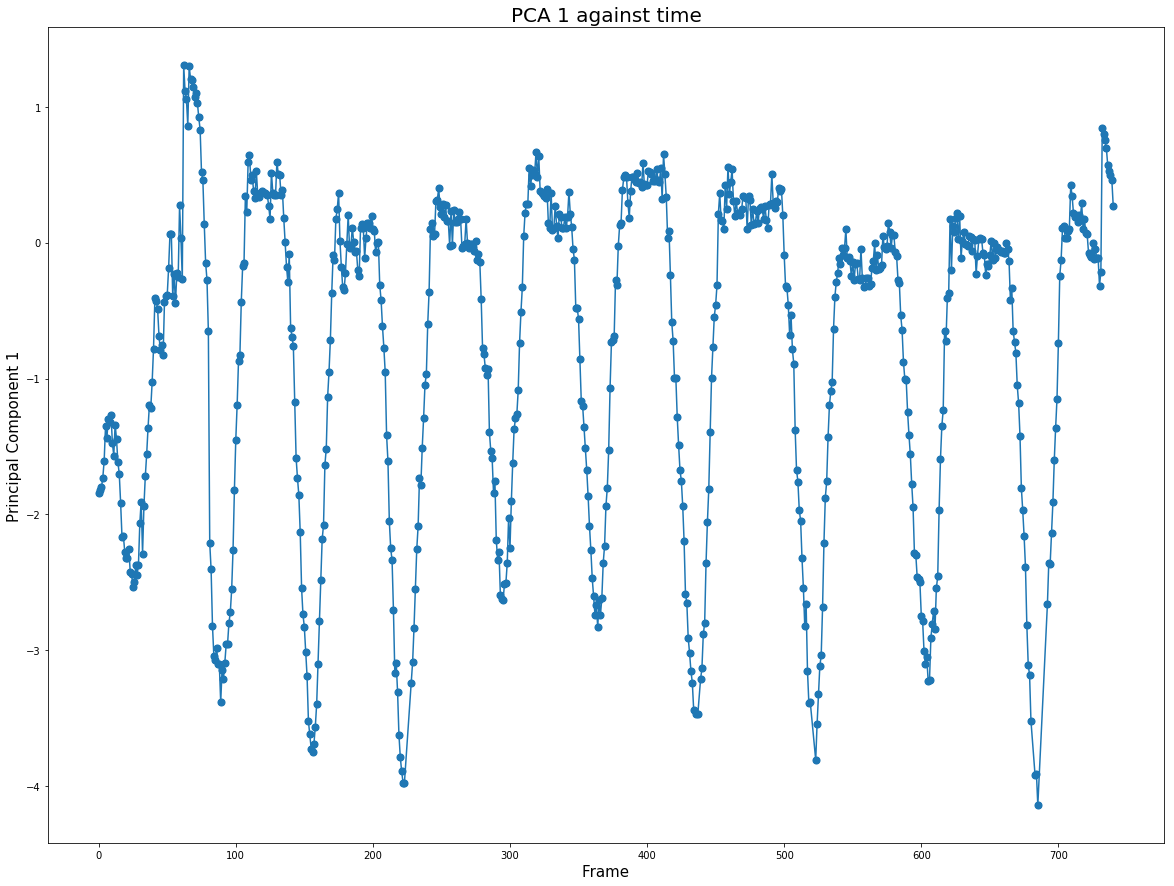

Arm 6
[0.85380666 0.04596031]


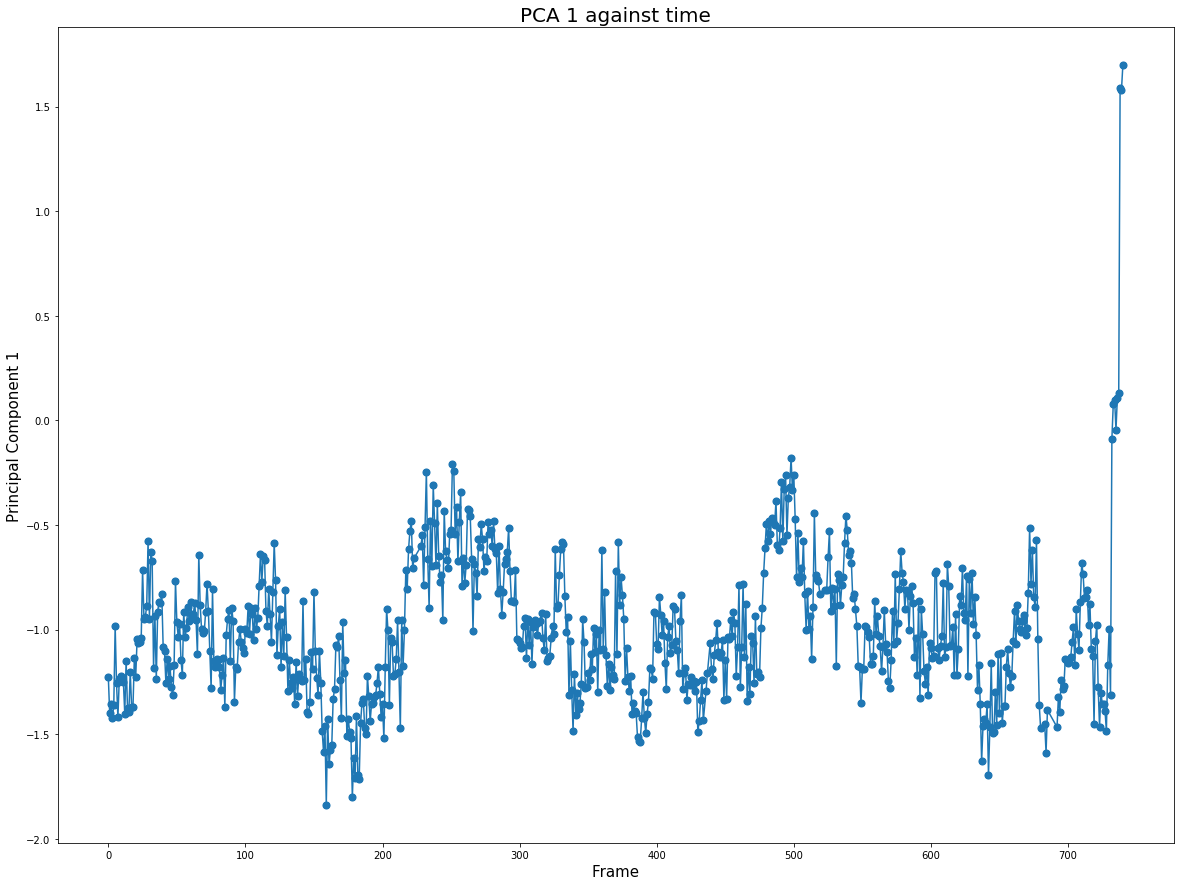

Squat 7
[0.47793523 0.21906002]


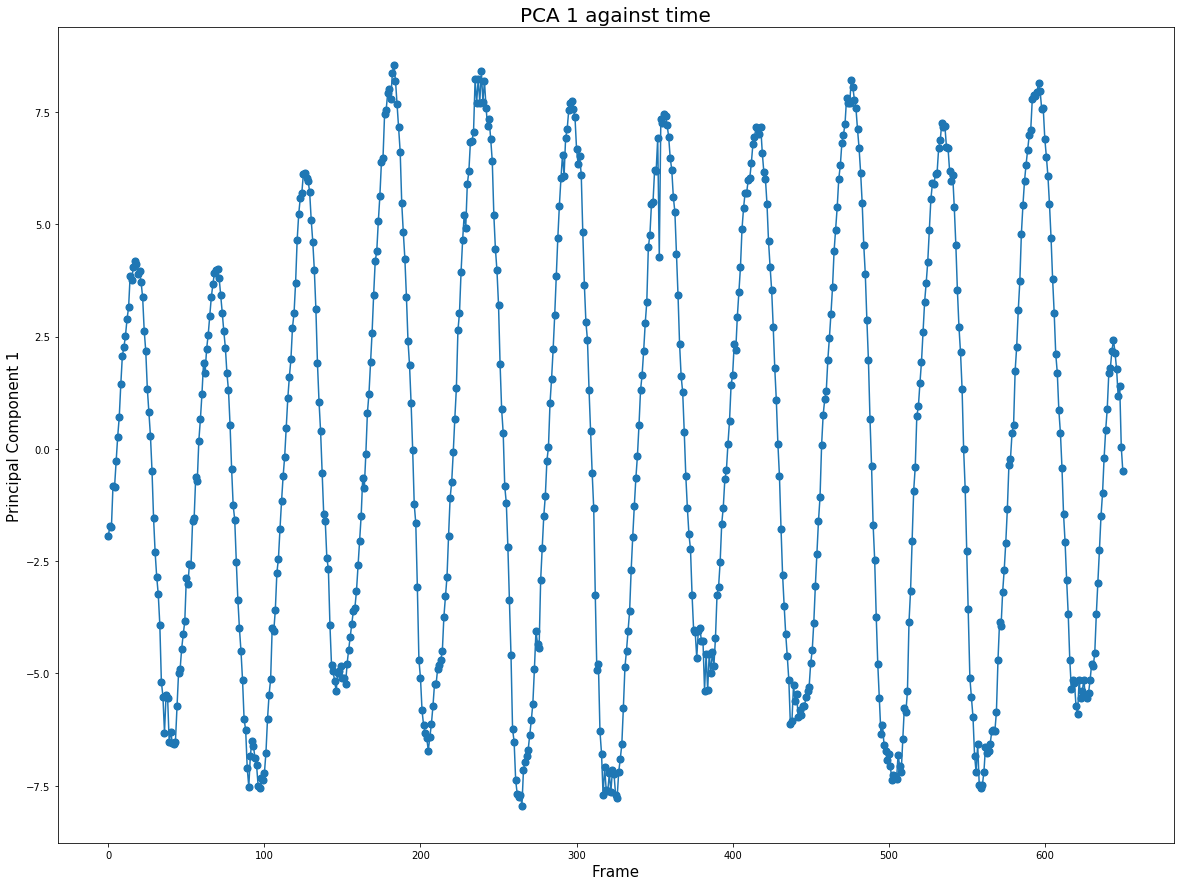

Arm 7
[0.26096683 0.14931317]


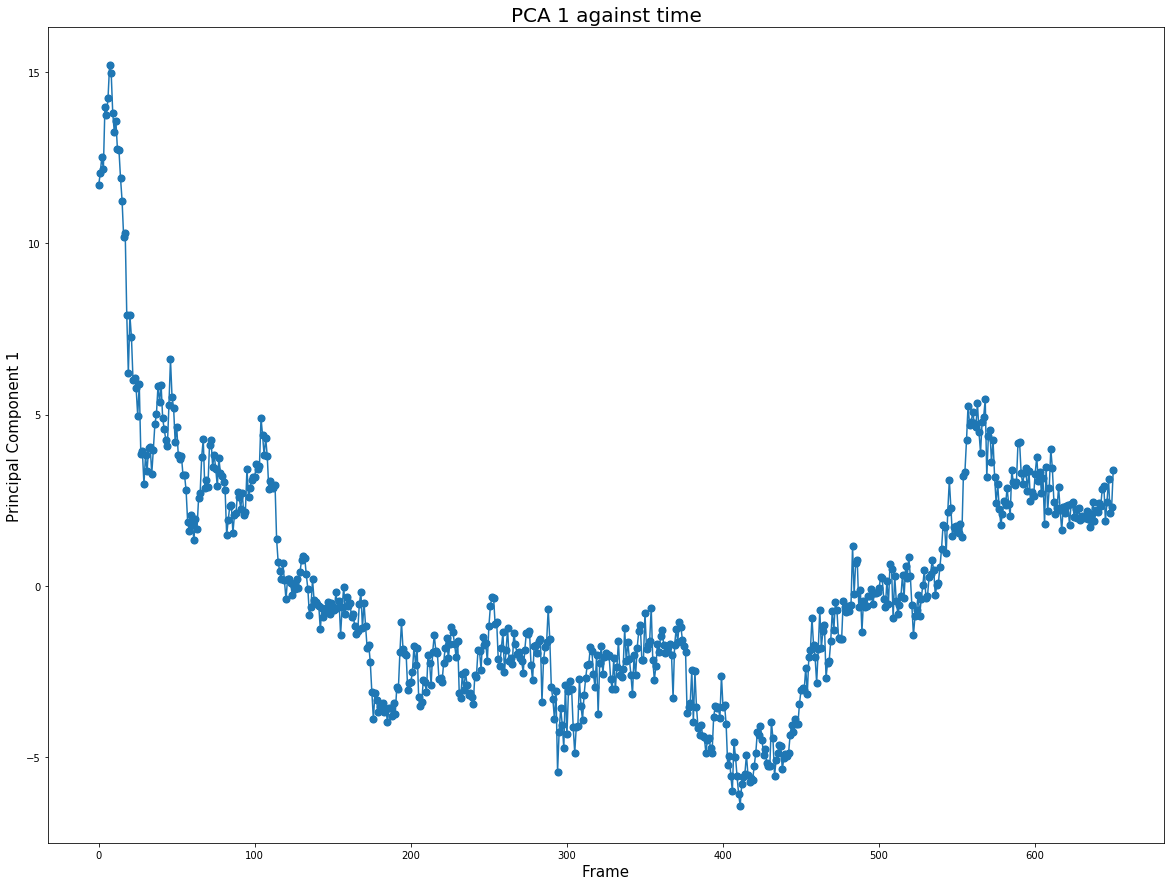

Squat 8
[0.53705492 0.32795337]


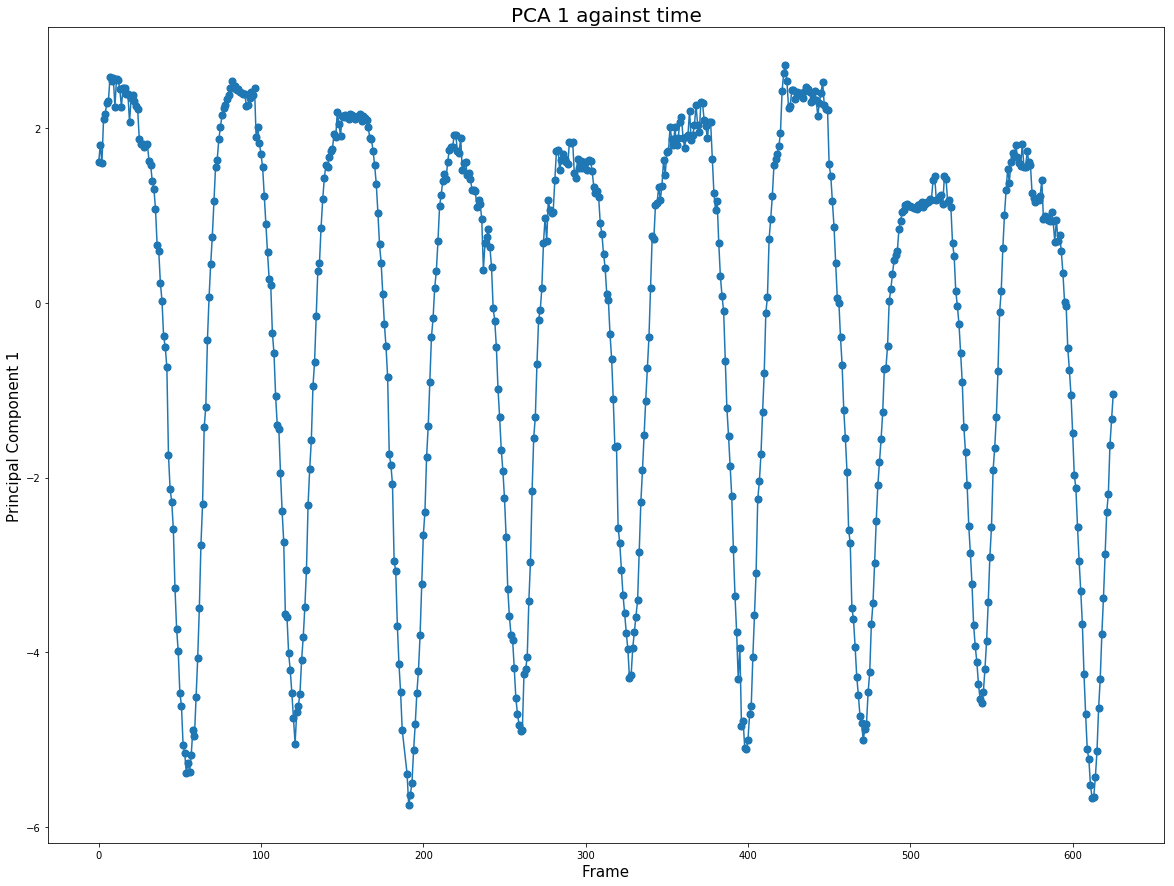

Arm 8
[0.64866767 0.14431179]


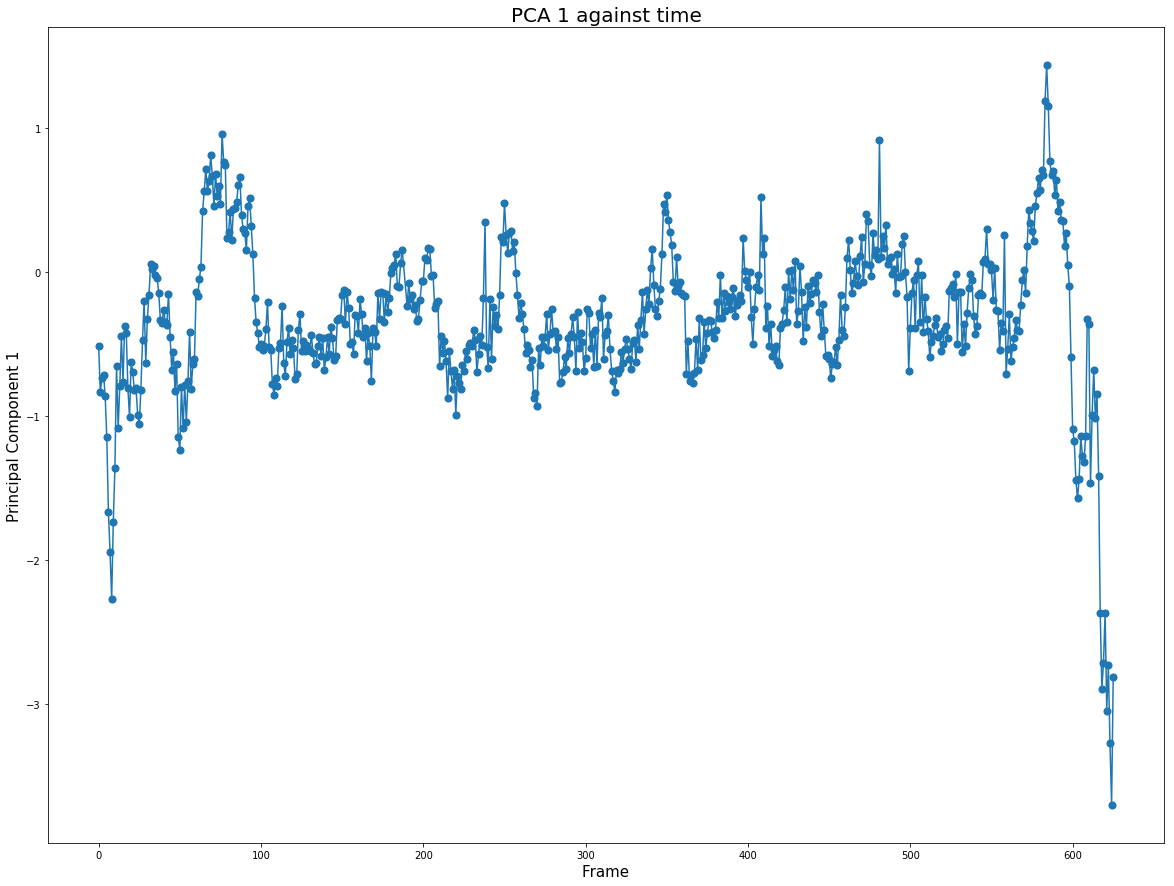

Squat 9
[0.47069562 0.0940811 ]


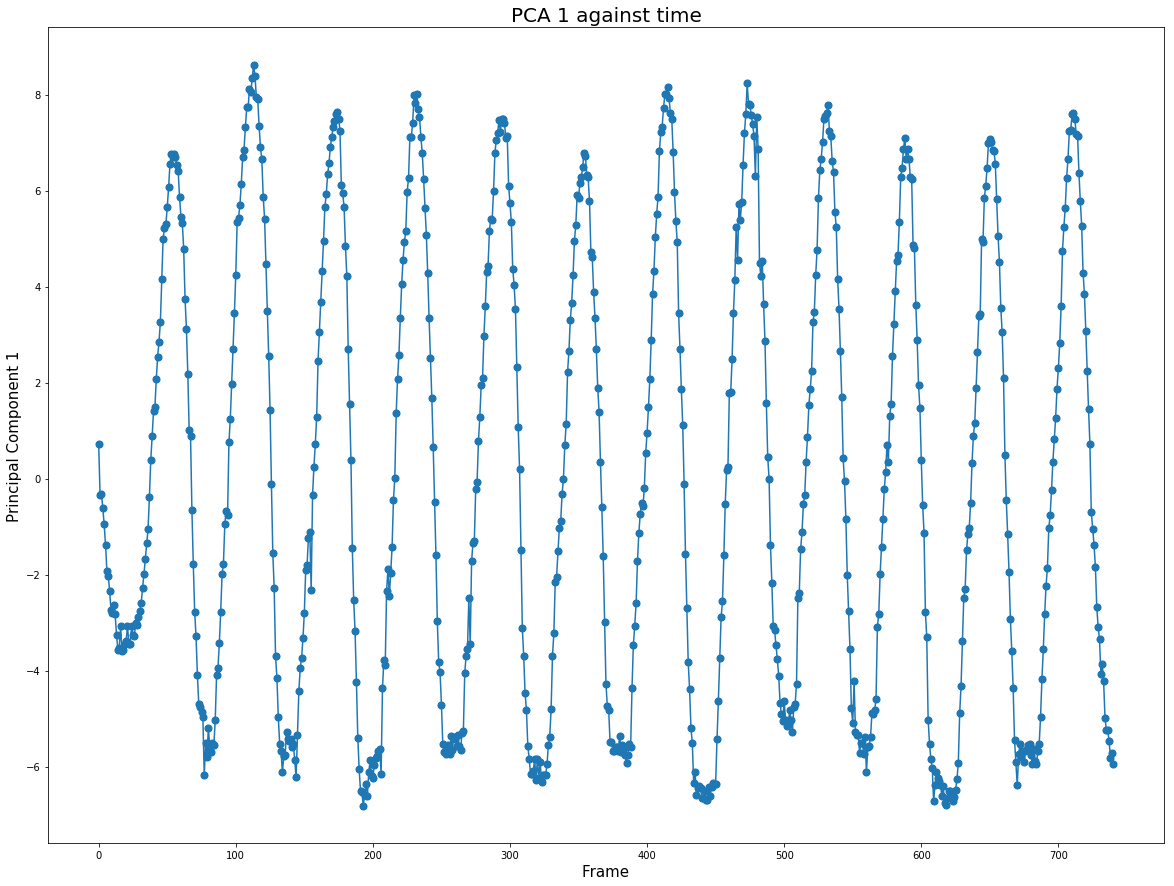

Arm 9
[0.34418068 0.1474781 ]


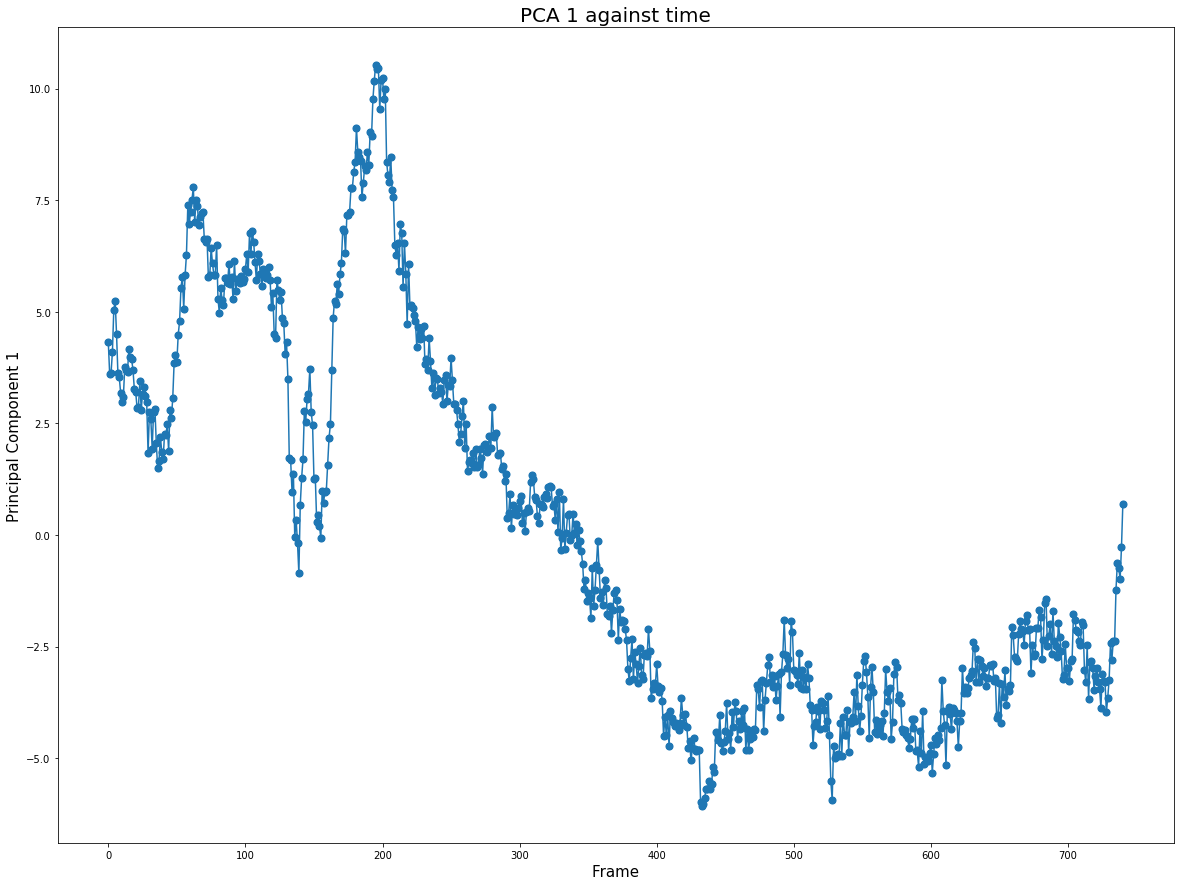

In [55]:
print("Squat 1")
pcaAnalysis(pca_data_one, 135, 800, 50)
print("Arm 1")
pcaAnalysis(pca_data_two, 135, 800, 50)
print("Squat 2")
pcaAnalysis(pca_data_three, 1230, 1910, 50)
print("Arm 2")
pcaAnalysis(pca_data_four, 1230, 1910, 50)
print("Squat 3")
pcaAnalysis(pca_data_five, 2700, 3350, 50)
print("Arm 3")
pcaAnalysis(pca_data_six, 2700, 3350, 50)
print("Squat 4")
pcaAnalysis(pca_data_seven, 3600, 4280, 50)
print("Arm 4")
pcaAnalysis(pca_data_eight, 3600, 4280, 50)
print("Squat 5")
pcaAnalysis(pca_data_9, 210, 930, 50)
print("Arm 5")
pcaAnalysis(pca_data_10, 210, 930, 50)
print("Squat 6")
pcaAnalysis(pca_data_11, 1250, 1990, 50)
print("Arm 6")
pcaAnalysis(pca_data_12, 1250, 1990, 50)
print("Squat 7")
pcaAnalysis(pca_data_13, 2330, 2980, 50)
print("Arm 7")
pcaAnalysis(pca_data_14, 2330, 2980, 50)
print("Squat 8")
pcaAnalysis(pca_data_15, 3725, 4350, 50)
print("Arm 8")
pcaAnalysis(pca_data_16, 3725, 4350, 50)
print("Squat 9")
pcaAnalysis(pca_data_17, 4585, 5325, 50)
print("Arm 9")
pcaAnalysis(pca_data_18, 4585, 5325, 50)

Arm 1 with just hands


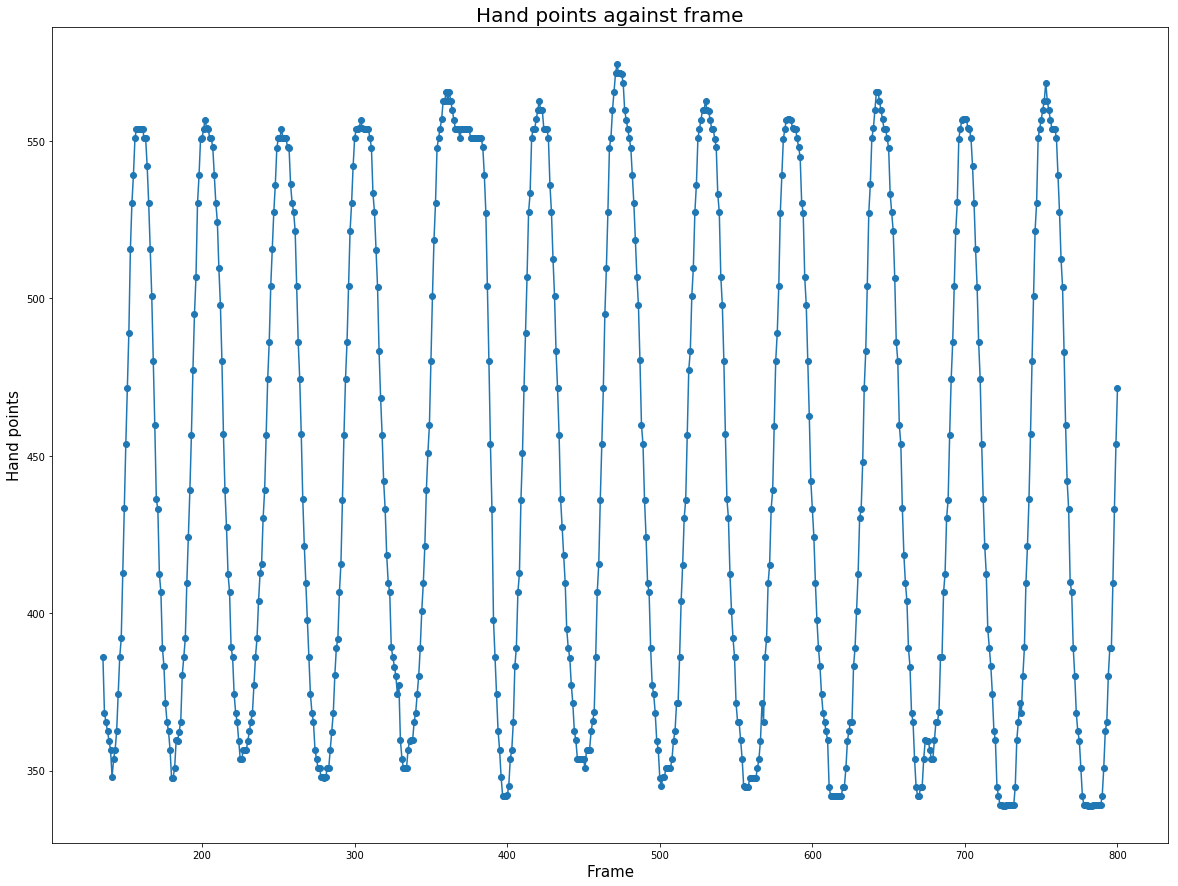

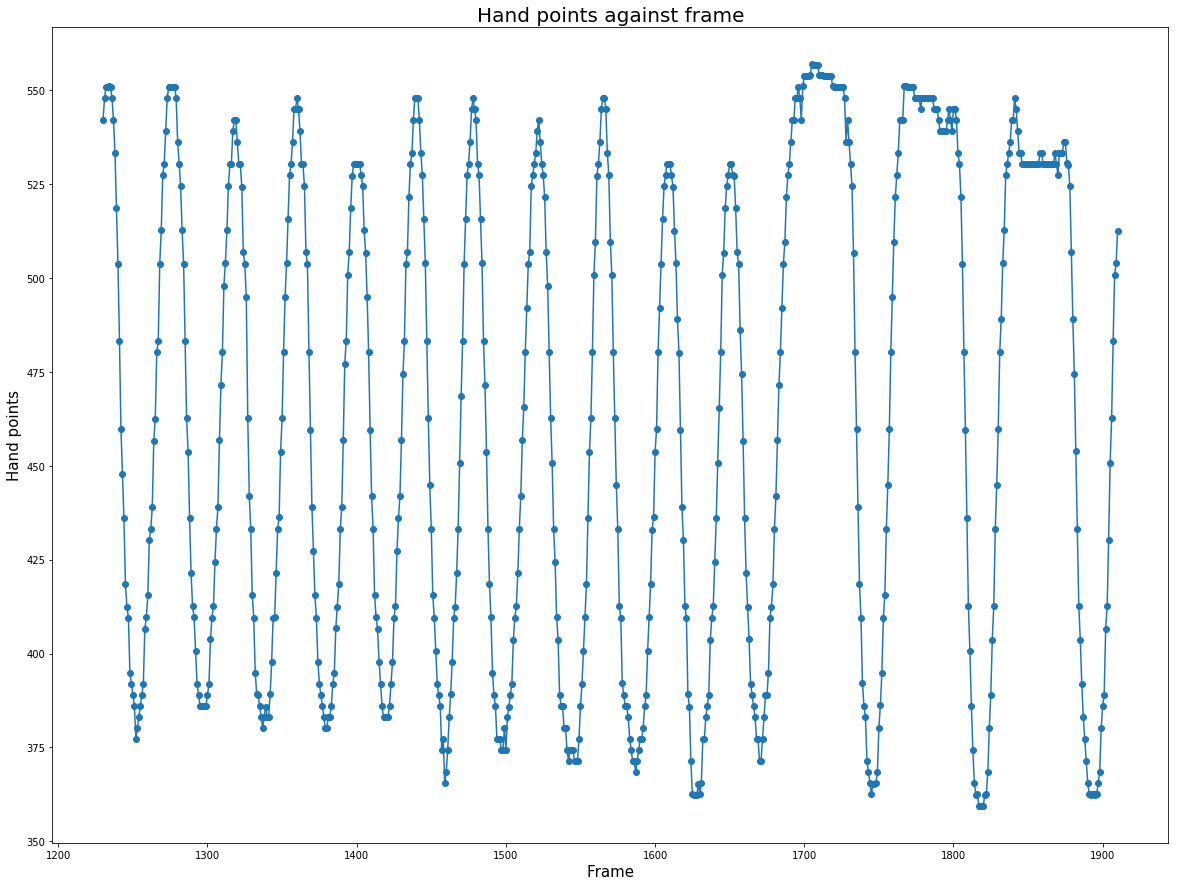

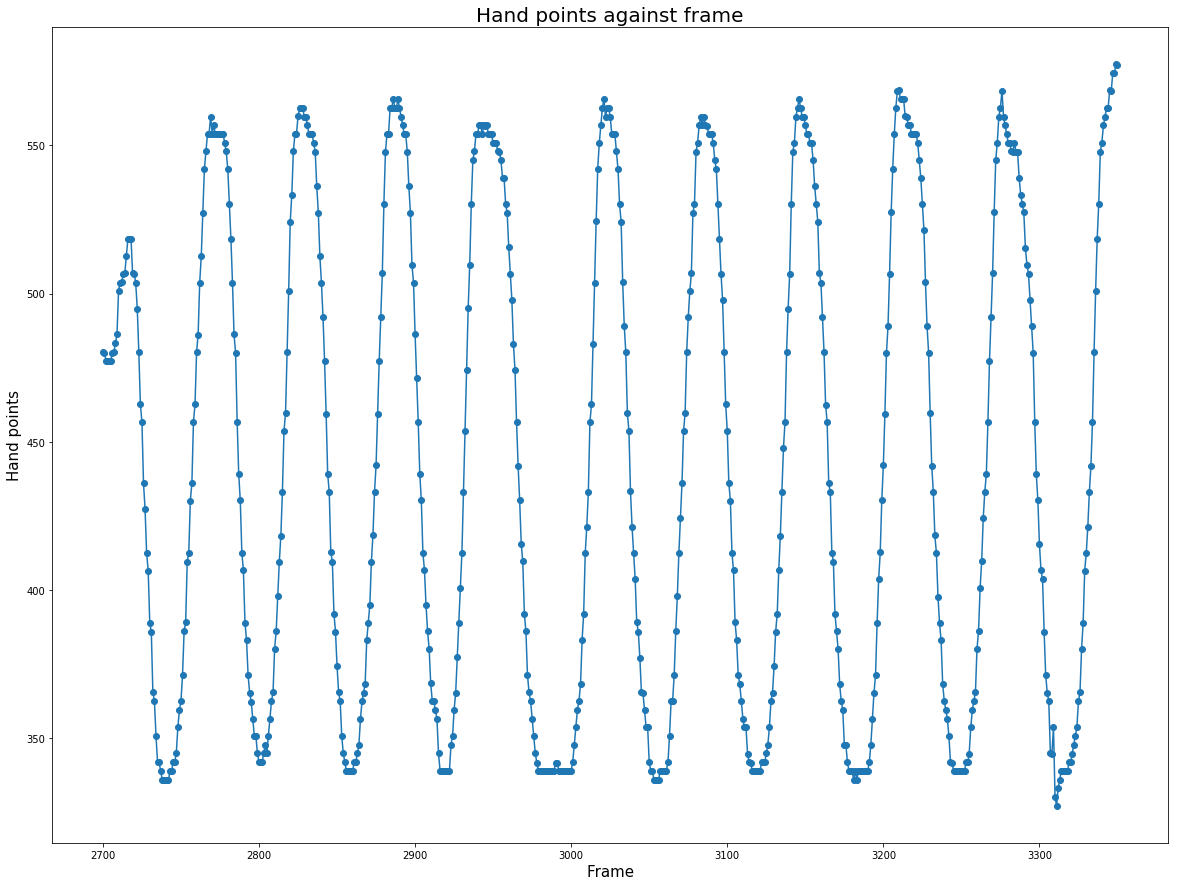

In [58]:
print("Arm 1 with just hands")
hand_one = only_hand(exercise_two, 135, 800)
pcaAnalysis(hand_one, 135, 800, 2)
hand_two = only_hand(exercise_four, 1230, 1910)
pcaAnalysis(hand_two, 1230, 1910, 2)
hand_three = only_hand(exercise_six, 2700, 3350)
pcaAnalysis(hand_three, 2700, 3350, 2)

In [38]:
# with open('Sample1.json', 'w') as fp:
#     json.dump(one_flattered, fp)

# with open('Sample2.json', 'w') as fp:
#     json.dump(two_flattered, fp)

# with open('Sample3.json', 'w') as fp:
#     json.dump(three_flattered, fp)
    
# with open('Sample4.json', 'w') as fp:
#     json.dump(four_flattered, fp)
    
# with open('Sample5.json', 'w') as fp:
#     json.dump(five_flattered, fp)
    
# with open('Sample6.json', 'w') as fp:
#     json.dump(six_flattered, fp)
    
# with open('Sample7.json', 'w') as fp:
#     json.dump(seven_flattered, fp)
    
# with open('Sample8.json', 'w') as fp:
#     json.dump(eight_flattered, fp)
    